<a href="https://colab.research.google.com/github/MinsooKwak/Kaggle_note/blob/main/DataScience/titanic_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참조 note:

https://www.kaggle.com/code/ydalat/titanic-a-step-by-step-intro-to-machine-learning/notebook



Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
import re

In [2]:
import matplotlib.font_manager as fm  # 폰트 관련 용도
#!sudo apt-get install -y fonts-nanum  ## 폰트설치
#!sudo fc-cache -fv ## 폰트 업데이트
#!rm ~/.cache/matplotlib -rf ## 캐쉬된 matplotlib 폰트 삭제하여 재로딩

In [3]:
# ttflist에 Nanum 글자 들어가는 폰트 있는지 확인하는 코드
f = [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
f

['NanumSquareRound',
 'NanumGothic',
 'NanumGothic',
 'NanumBarunGothic',
 'NanumBarunGothic',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumSquare',
 'NanumSquareRound',
 'NanumMyeongjo']

In [4]:
#폰트종류설정
plt.rcParams["font.family"] ='NanumSquare'

# 현재 설정되어 있는 폰트 사이즈와 글꼴을 알아보자
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

Python 3.7.13
설정 폰트 글꼴: ['NanumSquare'], 설정 폰트 사이즈: 10.0


In [5]:
path = '/content/drive/MyDrive/text/NanumSquareR.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumSquare


In [6]:
import xgboost as xgb
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, confusion_matrix

In [7]:
import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train = pd.read_csv('/content/drive/MyDrive/kaggle/titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/kaggle/titanic/test.csv')

In [10]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [11]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


*target = Survived

Train set 결측치 확인

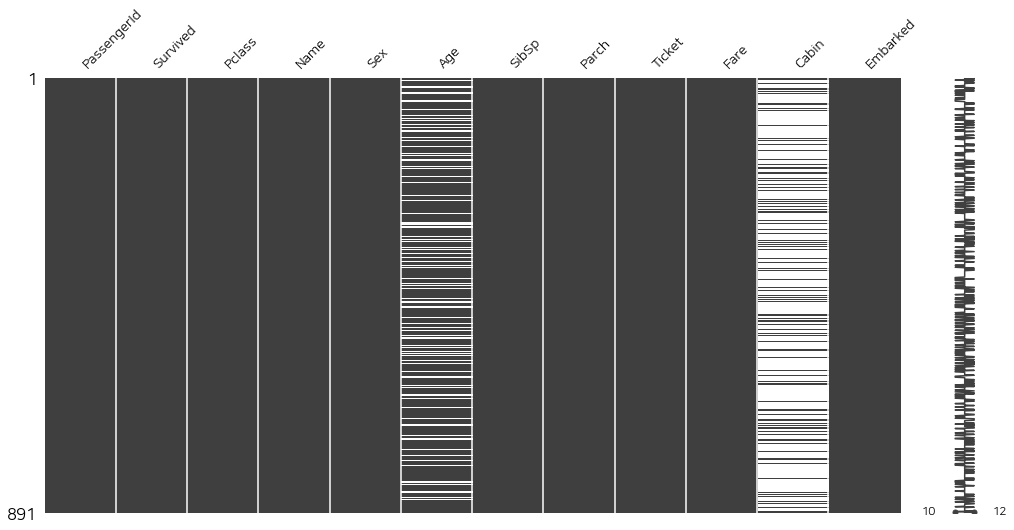

In [12]:
msno.matrix(train, figsize=(17,8), fontsize=14);

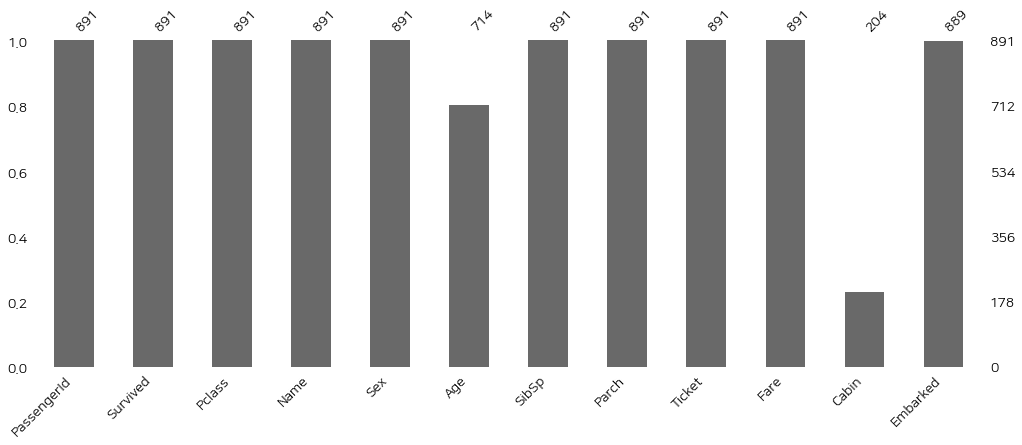

In [13]:
msno.bar(train, figsize=(17,6), fontsize=14);

In [14]:
for i in train.columns:
  null_rate = train[i].isna().sum() / len(train)*100
  if null_rate > 0:
    print(f"{i}'s null rate : {null_rate.round(2)}%")

Age's null rate : 19.87%
Cabin's null rate : 77.1%
Embarked's null rate : 0.22%


In [15]:
PassengerId = test['PassengerId']

In [16]:
train.PassengerId.nunique()

891

PassengerId가 unique한 것을 알 수 있음

In [17]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Data type

In [18]:
print('카테고리 수 알아보기')
print(f'PassengerId   : {train.PassengerId.nunique()}')
print(f'Survived      : {train.Survived.nunique()}')
print(f'Pclass        : {train.Pclass.nunique()}')
print(f'Name          : {train.Name.nunique()}')
print(f'Sex           : {train.Sex.nunique()}')
print(f'Age           : {train.Age.nunique()}')
print(f'SibSp         : {train.SibSp.nunique()}')
print(f'Parch         : {train.Parch.nunique()}')
print(f'Ticket        : {train.Ticket.nunique()}')
print(f'Fare          : {train.Fare.nunique()}')
print(f'Cabin         : {train.Cabin.nunique()}')
print(f'Embarked      : {train.Embarked.nunique()}')

카테고리 수 알아보기
PassengerId   : 891
Survived      : 2
Pclass        : 3
Name          : 891
Sex           : 2
Age           : 88
SibSp         : 7
Parch         : 7
Ticket        : 681
Fare          : 248
Cabin         : 147
Embarked      : 3


- 범주형 : **Survived, Pclass, Sex, SibSp, Parch, Embarked**, Cabin
- 수치형 : PassengerId, Name, **Age, Ticket, Fare**

In [19]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

First look into data

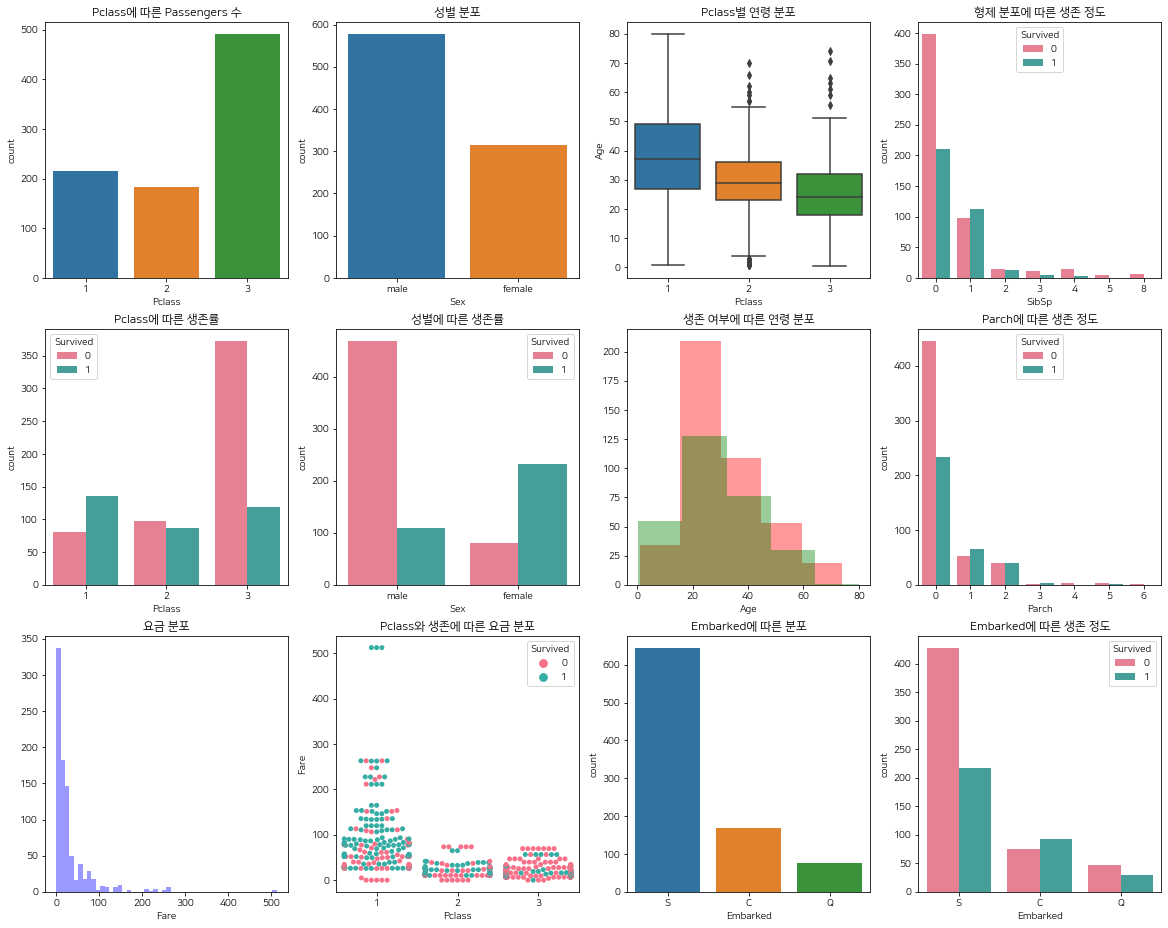

In [20]:
f,ax = plt.subplots(3,4,figsize=(20,16))
# Pclass 분포 확인
ax[0,0].set_title('Pclass에 따른 Passengers 수')
sns.countplot('Pclass', data=train, ax=ax[0,0])
# Sex 분포 확인
ax[0,1].set_title('성별 분포')
sns.countplot('Sex', data=train, ax=ax[0,1])
# Pclass별 Age 분포 boxplot
ax[0,2].set_title('Pclass별 연령 분포')
sns.boxplot(x='Pclass', y='Age', data=train, ax=ax[0,2])
# SibSp에 따른 생존정도 분포
ax[0,3].set_title('형제 분포에 따른 생존 정도')
sns.countplot('SibSp', hue='Survived', data=train, ax=ax[0,3], palette='husl')
# Fare 요금 분포
ax[2,0].set_title('요금 분포')
sns.distplot(train['Fare'].dropna(), ax=ax[2,0], kde=False, color='b')
# Embarked 분포
ax[2,2].set_title('Embarked에 따른 분포')
sns.countplot('Embarked',data=train, ax=ax[2,2])

# Pclass별 생존 분포
ax[1,0].set_title('Pclass에 따른 생존률')
sns.countplot('Pclass', hue='Survived', data=train, ax=ax[1,0], palette='husl')
# Sex별 생존 분포
ax[1,1].set_title('성별에 따른 생존률')
sns.countplot('Sex', hue='Survived', data=train, ax=ax[1,1], palette='husl')
# 생존하지 못한 사람들의 나이 분포
ax[1,2].set_title('생존 여부에 따른 연령 분포')
sns.distplot(train[train['Survived']==0]['Age'].dropna(), ax=ax[1,2], kde=False, color='r', bins=5)
# 생존한 사람들의 나이 분포
sns.distplot(train[train['Survived']==1]['Age'].dropna(), ax=ax[1,2],kde=False, color='g', bins=5)

ax[1,3].set_title('Parch에 따른 생존 정도')
sns.countplot('Parch',hue='Survived', data=train, ax=ax[1,3], palette='husl')
ax[2,1].set_title('Pclass와 생존에 따른 요금 분포')
sns.swarmplot(x='Pclass',y='Fare', hue='Survived', data=train, palette='husl', ax=ax[2,1])
ax[2,3].set_title('Embarked에 따른 생존 정도')
sns.countplot('Embarked',hue='Survived', data=train, ax=ax[2,3], palette='husl')

## EDA, Cleaning and Feature Engineering

In [21]:
# Outlier Detection Function
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index       
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   
  
# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age','SibSp','Parch','Fare'])
train.loc[Outliers_to_drop] # Show outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 이상치 개수: 10
- High Ticket Fare : PassengerId 28, 89, 342
- High SibSp : 나머지 이상치

In [22]:
# Drop outlier
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

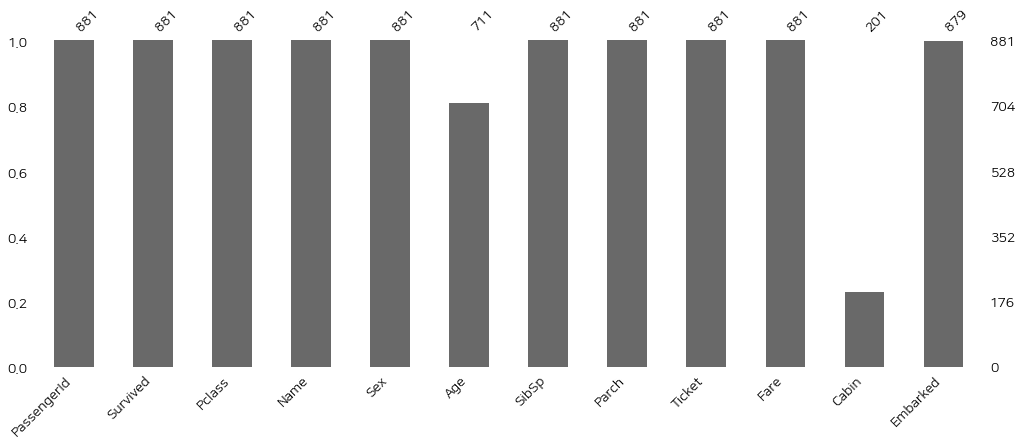

In [23]:
msno.bar(train, figsize=(17,6), fontsize=14);

In [24]:
# Age 결측치 제거, Cabin의 경우는 사용하지 않는 것이 좋을 것 같음
train = train[~train['Age'].isna()]

In [25]:
train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  711 non-null    int64  
 1   Survived     711 non-null    int64  
 2   Pclass       711 non-null    int64  
 3   Name         711 non-null    object 
 4   Sex          711 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        711 non-null    int64  
 7   Parch        711 non-null    int64  
 8   Ticket       711 non-null    object 
 9   Fare         711 non-null    float64
 10  Cabin        182 non-null    object 
 11  Embarked     709 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.2+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [26]:
full_data = [train, test]
Survival = train['Survived']
Survival.describe()

count    711.000000
mean       0.405063
std        0.491250
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

Pclass

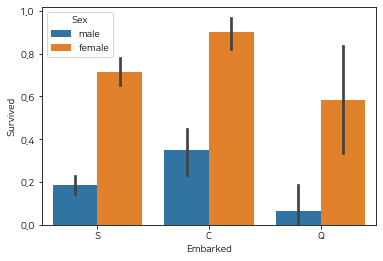

In [27]:
sns.barplot(x='Embarked',y='Survived', hue='Sex', data=train)

Gender

In [28]:
for dataset in full_data:
  dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

Age

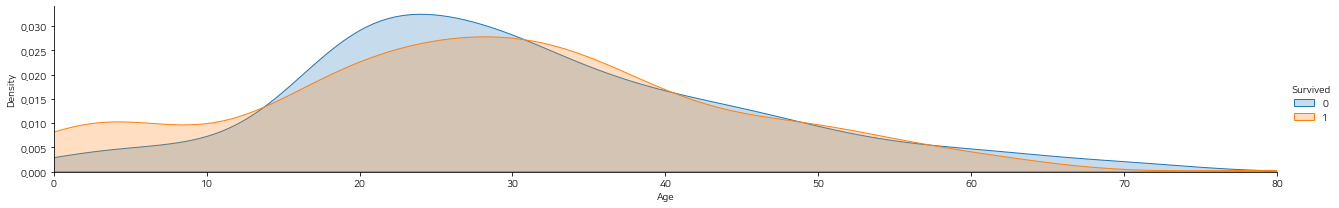

In [29]:
a = sns.FacetGrid(train, hue='Survived', aspect=6)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0, train['Age'].max()))
a.add_legend()

Age에 대한 범주 구분

- 0: 0~14
- 1: 14~30
- 2: 30~40
- 3: 40~50
- 4: 50~60
- 5: 60~

In [30]:
for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])]= age_null_random_list
  dataset['Age']= dataset['Age'].astype(int)

  dataset.loc[dataset['Age']<=14, 'Age']=0
  dataset.loc[(dataset['Age']>14) & (dataset['Age']<=30), 'Age']=1
  dataset.loc[(dataset['Age']>30) & (dataset['Age']<=40), 'Age']=2
  dataset.loc[(dataset['Age']>40) & (dataset['Age']<=50), 'Age']=3
  dataset.loc[(dataset['Age']>50) & (dataset['Age']<=60), 'Age']=4
  dataset.loc[(dataset['Age'])>60, 'Age']=5

train['Age'].value_counts()

1    330
2    155
3     84
0     78
4     42
5     22
Name: Age, dtype: int64

In [31]:
dataset['Age']

0      2
1      3
2      5
3      1
4      1
      ..
413    2
414    2
415    2
416    1
417    2
Name: Age, Length: 418, dtype: int64

In [32]:
train[['Age','Survived']].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending = False)

,Age,Survived
0,0,0.576923
2,2,0.445161
4,4,0.404762
3,3,0.392857
1,1,0.360606
5,5,0.227273


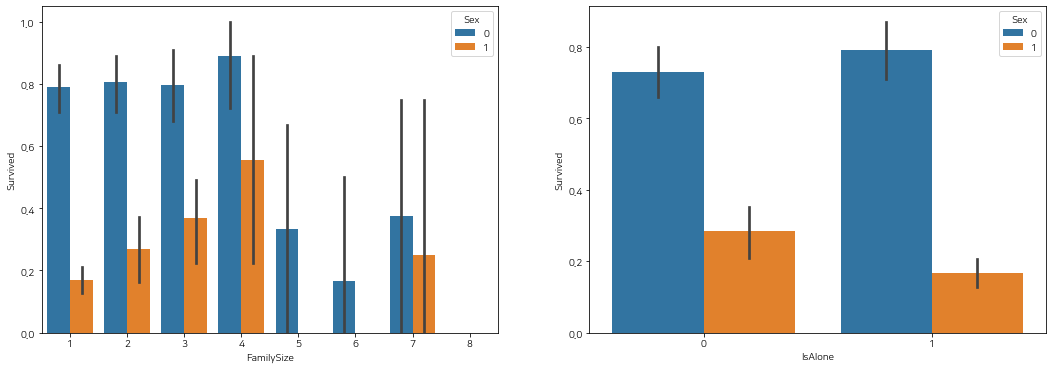

In [33]:
for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']+1
  dataset['IsAlone']=0
  dataset.loc[dataset['FamilySize']==1, 'IsAlone']=1

  dataset['Boys']=0
  dataset.loc[(dataset['Age']==0) & (dataset['Sex']==1), 'Boys']=1

fig, (axis1,axis2) = plt.subplots(1,2, figsize=(18,6))
sns.barplot(x='FamilySize', y='Survived', hue='Sex',data=train, ax=axis1)
sns.barplot(x='IsAlone', y='Survived', hue='Sex', data=train, ax=axis2)

Fare

In [34]:
import cufflinks as cf
cf.go_offline()
train['Fare'].iplot(kind='hist', bins=30)

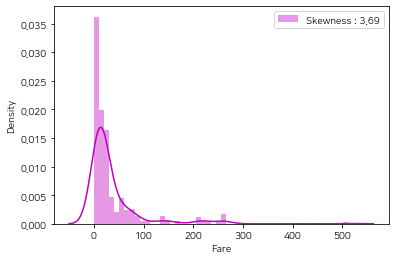

In [35]:
for dataset in full_data:
  # imputation with median
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Fare distribution
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

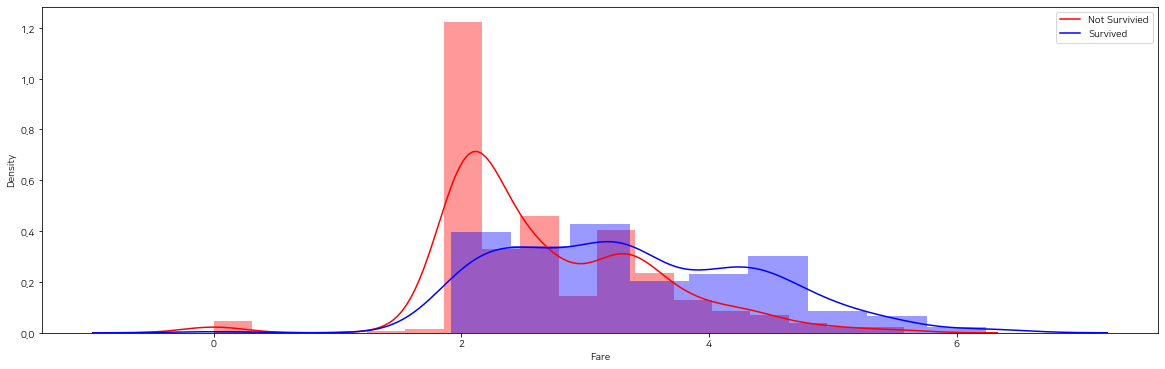

In [36]:
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

fig, ax = pyplot.subplots(figsize=(20,6))
g = sns.distplot(train['Fare'][train['Survived']==0], color='r', label='skewness : %.2f'%(train['Fare'].skew()), ax=ax)
g = sns.distplot(train['Fare'][train['Survived']==1], color='b', label='skewness : %.2f'%(train['Fare'].skew()), ax=ax)

g =g.legend(['Not Survivied','Survived'])

Log Fare categories:
- 0~2.7 : less survivors
- 2.7 이상: more survivors

In [37]:
for dataset in full_data:
  dataset.loc[dataset['Fare'] <=2.7, 'Fare']=0
  dataset.loc[dataset['Fare']>2.7, 'Fare']=1
  dataset['Fare']= dataset['Fare'].astype(int)
train['Fare'].value_counts()

1    362
0    349
Name: Fare, dtype: int64

Cabin

In [40]:
for dataset in full_data:
  dataset['Has_Cabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

train[["Has_Cabin", "Survived"]].groupby(['Has_Cabin'], as_index=False).sum().sort_values(by='Survived', ascending=False)

,Has_Cabin,Survived
0,0,165
1,1,123


In [41]:
train[['Has_Cabin','Survived']].groupby(['Has_Cabin'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Has_Cabin,Survived
1,1,0.675824
0,0,0.311909


Embarked

In [42]:
for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')
  dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

In [44]:
train_pivot = pd.pivot_table(train, values='Survived', index=['Embarked'],
                             columns='Pclass', aggfunc=np.mean, margins=True)

def color_negative_red(val):
  color = 'red' if val <0.4 else 'black'
  return 'color: %s' %color

train_pivot = train_pivot.style.applymap(color_negative_red)
train_pivot

Pclass,1,2,3,All
Embarked,,,,
0,0.616822,0.474359,0.210345,0.363472
1,0.716216,0.533333,0.439024,0.607692
2,0.500000,0.500000,0.250000,0.285714
All,0.655738,0.479769,0.239437,0.405063


In [45]:
dataset['Embarked'] = dataset['Embarked'].replace(['0','2'],'0')
train['Fare'].value_counts()

1    362
0    349
Name: Fare, dtype: int64

Extract deck from cabin

In [49]:
deck = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'U':8}

for dataset in full_data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int) 
    
train['Deck'].value_counts()

8    529
3     48
2     45
4     31
5     30
1     12
6     11
7      4
0      1
Name: Deck, dtype: int64

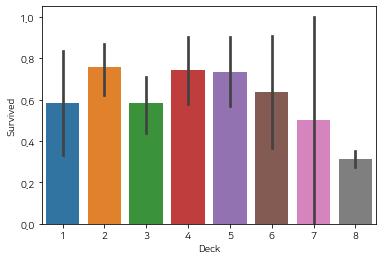

In [50]:
sns.barplot(x='Deck', y='Survived', order=[1,2,3,4,5,6,7,8], data=train)

In [51]:
for dataset in full_data:
  dataset.loc[dataset['Deck']<=1, 'Deck']=1
  dataset.loc[(dataset['Deck']>1) & (dataset['Deck']<=6), 'Deck']=3
  dataset.loc[dataset['Deck']>6, 'Deck']=0

train[['Deck','Survived']].groupby(['Deck'], as_index=False).mean().sort_values(by='Survived',ascending=False)

,Deck,Survived
2,3,0.690909
1,1,0.538462
0,0,0.313321


## Visualize updated Dataset

In [52]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Boys,Has_Cabin,Deck
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,U0,0,2,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,1,C85,1,2,0,0,1,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,0,U0,0,1,1,0,0,0


In [53]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Boys,Has_Cabin,Deck
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,U0,2,1,1,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,3,1,0,363272,0,U0,0,2,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,5,0,0,240276,0,U0,2,1,1,0,0,0


## Descriptive statistics

In [54]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Boys,Has_Cabin,Deck
count,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000
mean,449.829817,0.405063,2.241913,0.635724,1.645570,0.502110,0.424754,0.509142,0.261603,1.926864,0.568214,0.054852,0.255977,0.714487
std,258.800735,0.491250,0.836147,0.481565,1.188373,0.917549,0.848963,0.500268,0.521836,1.463257,0.495674,0.227852,0.436716,1.264377
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,447.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,678.500000,1.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.500000
max,891.000000,1.000000,3.000000,1.000000,5.000000,5.000000,6.000000,1.000000,2.000000,8.000000,1.000000,1.000000,1.000000,3.000000


In [55]:
train[['Pclass','Sex','Age','Parch','Fare','Embarked','Has_Cabin','FamilySize','Survived']].groupby(['Survived'],as_index=False).mean().sort_values(by='Pclass',ascending=False)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize
0,0,2.489362,0.848700,1.704492,0.361702,0.390071,0.215130,0.139480,1.881797
1,1,1.878472,0.322917,1.559028,0.517361,0.684028,0.329861,0.427083,1.993056


- Pclass : more expensive class has much higher chance of surviving
- Fare : higher fare higher chance to survive
- Cabin : Having Cabin increases the chance of survival
- Woman(0) higher chance than Man(1)
- Younger people slightly more chance than older
- Being alone decreased your chance to survive

## Correlation analysis